Notebook purpose

- Determine appropriate model specifications

Background: 

- avg hh savings in uk: https://www.nimblefins.co.uk/savings-accounts/average-household-savings-uk#nogo

In [157]:
import os
import re
import sys

import linearmodels as lm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.figures.figures as figs
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load raw data

In [4]:
dfs, df = hd.read_samples(["777", "XX7"])
hd.inspect(df)

Time for read_sample    : 2.40 seconds
Time for read_sample    : 5.41 minutes
(14,839,981, 31)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,entropy_sptac
0,1859849,2012-11-05,57,-700.0,faster payments receipt ref mdbremoved,NaN,NaN,NaN,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2012-10-23,274000,2020-08-16 07:24:00,santander,current,2014-07-18,2017-08-15,False,14829.769531,NaN,NaN,NaN,current account,u,201211,8504.292969,22136.039062,2.397678
1,1859848,2012-11-08,57,-900.0,faster payments receipt from mdbremoved,NaN,NaN,NaN,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2012-10-23,274000,2020-08-16 07:24:00,santander,current,2014-07-18,2017-08-15,False,14829.769531,NaN,NaN,NaN,current account,u,201211,9404.292969,22136.039062,2.397678


## Make analysis data

Make user-ym panel comprising dependent and independent variables

In [154]:
month = pd.Grouper(key="date", freq="m")
idx_cols = ["user_id", month]

column_makers = []


def column_adder(func):
    column_makers.append(func)
    return func


@column_adder
def obs_count(df):
    return df.groupby(idx_cols).id.count().rename("obs")


@column_adder
def total_monthly_spend(df):
    mask = df.tag_group.eq("spend")
    return df[mask].groupby(idx_cols).amount.sum().rename("total_monthly_spend")


@column_adder
def tag_monthly_spend(df):
    df = df.copy()
    df["tag"] = df.tag.cat.rename_categories(lambda x: "tag_spend_" + x)
    mask = df.tag_group.eq("spend")
    group_cols = idx_cols + ["tag"]
    return df[mask].groupby(group_cols, observed=True).amount.sum().unstack().fillna(0)


@column_adder
def account_balances(df):
    """Calculates average monthly balances for user's savings and current accounts."""
    return (
        df
        # daily account balances
        .groupby(
            ["user_id", "account_type", "account_id", "date"],
            observed=True,
        )
        .balance.first()
        # daily account type balances
        .groupby(["user_id", "account_type", "date"], observed=True)
        .sum()
        # monthly account type mean balance
        .reset_index()
        .set_index("date")
        .groupby(["user_id", "account_type"])
        .balance.resample("m")
        .mean()
        # reformat
        .unstack(level="account_type")
        .rename(columns={"current": "balance_ca", "savings": "balance_sa"})
    )


@column_adder
def savings_accounts_flows(df):
    """Calculates monthly inflows, outflows, and net-inflows into user's savings accounts."""
    df = df.copy()
    df["debit"] = df.debit.replace({True: "sa_outflows", False: "sa_inflows"})
    is_not_interest_txn = ~df.tag_auto.str.contains("interest", na=False)
    is_savings_account = df.account_type.eq("savings")
    mask = is_not_interest_txn & is_savings_account
    group_cols = idx_cols + ["income", "debit"]

    return (
        df[mask]
        .groupby(group_cols)
        .amount.sum()
        .abs()
        .unstack()
        .fillna(0)
        .reset_index("income")
        .assign(
            sa_net_inflows=lambda df: df.sa_inflows - df.sa_outflows,
            sa_scaled_inflows=lambda df: df.sa_inflows / (df.income / 12) * 100,
            sa_scaled_outflows=lambda df: df.sa_outflows / (df.income / 12) * 100,
            sa_scaled_net_inflows=lambda df: df.sa_scaled_inflows
            - df.sa_scaled_outflows,
        )
        .drop(columns="income")
    )


def main(df):
    return pd.concat((func(df) for func in column_makers), axis=1)


# data = main(df)
# filepath = "/Users/fgu/tmp/en/analysis_data_XX7.parquet"
# ha.write_parquet(data, filepath, index=True)
data = ha.read_parquet(filepath)
hd.inspect(data)

(174,655, 19)


obs  total_monthly_spend  tag_spend_household  \
user_id date                                                         
57      2012-11-30  20.0          1411.040039          1230.430054   
        2012-12-31  32.0          1740.310059          1398.550049   

                    tag_spend_other_spend  tag_spend_services  \
user_id date                                                    
57      2012-11-30              90.000000           64.610001   
        2012-12-31             121.400002          129.759995   

                    tag_spend_travel  tag_spend_hobbies  tag_spend_retail  \
user_id date                                                                
57      2012-11-30         26.000000                0.0               0.0   
        2012-12-31         80.099998               10.5               0.0   

                    tag_spend_finance  tag_spend_communication  \
user_id date                                                     
57      2012-11-30                0.0                      0.0   
        2012-12-31                0.0                      0.0   

                    tag_spend_motor   balance_ca  balance_sa  sa_inflows  \
user_id date                                                               
57      2012-11-30              0.0  8447.646484         NaN         NaN   
        2012-12-31              0.0  8575.141602         NaN         NaN   

                    sa_outflows  sa_net_inflows  sa_scaled_inflows  \
user_id date                                                         
57      2012-11-30          NaN             NaN                NaN   
        2012-12-31          NaN             NaN                NaN   

                    sa_scaled_outflows  sa_scaled_net_inflows  
user_id date                                                   
57      2012-11-30                 NaN                    NaN  
        2012-12-31                 NaN                    NaN

## Sumstats

In [174]:
def trim_columns_upper(df, pct=0, ends="upper"):
    return df.apply(lambda x: hd.trim(x, pct=pct))


def colname_subset(df, pattern):
    """Returns names of all columns that contain pattern."""
    columns = df.columns
    return columns[columns.str.contains(pattern)]


def sumstats_table(df, cols):
    """Creats basic summary statistics table for colums."""
    order = ["count", "mean", "std", "min", "max", "25%", "50%", "75%"]
    return df[cols].pipe(trim_columns_upper, pct=5).describe().T[order]


cols = colname_subset(data, "\w")
sumstats_table(data, cols)

,count,mean,std,min,max,25%,50%,75%
obs,157120.0,81.384604,35.300652,25.000000,174.000000,53.000000,77.000000,105.000000
total_monthly_spend,156819.0,1488.823730,926.402649,121.570000,4390.580078,784.979980,1277.329956,2011.359985
tag_spend_household,156824.0,571.313232,497.254883,5.300000,2161.399902,180.164993,414.559998,845.885010
tag_spend_other_spend,156860.0,159.474976,168.906174,-105.940002,740.000000,30.000000,103.070000,240.000000
tag_spend_services,160645.0,239.838074,196.455658,0.000000,877.720032,87.720001,187.750000,344.720001
tag_spend_travel,164641.0,42.764732,68.719582,0.000000,340.580017,0.000000,12.250000,51.529999
tag_spend_hobbies,165173.0,10.366186,17.590151,0.000000,88.989998,0.000000,0.000000,14.990000
tag_spend_retail,156819.0,68.071938,83.403206,-11.230000,369.610016,0.000000,35.049999,103.989998
tag_spend_finance,157007.0,163.047714,218.659882,0.000000,1023.500000,11.315001,69.119995,226.114990
tag_spend_communication,164755.0,48.329262,38.255264,0.000000,161.759995,17.115000,42.450001,70.830002


### Example workflow for LaTeX summary table export

In [86]:
from contextlib import redirect_stdout

from tabulate import tabulate


def make_example_latex_table():
    table = ad.sa_inflows.describe().reset_index()
    return tabulate(
        table, tablefmt="latex_booktabs", colalign=["right", "right", "right"]
    )


def write_table(table, path):
    """Writes printed table to path."""
    with open(path, "w+") as f:
        with redirect_stdout(f):
            print(table)
    print(f"Table written to {path}.")


fp = "/Users/fgu/tmp/en/test.tex"
table = make_example_table()
write_latex_table(table, fp)
print(table)

Table written to /Users/fgu/tmp/en/test.tex.
\begin{tabular}{rrr}
\toprule
 0 & count &   57158 \\
 1 &  mean & 1060.95 \\
 2 &   std & 3742.03 \\
 3 &   min &       0 \\
 4 &   25\% &      50 \\
 5 &   50\% &     250 \\
 6 &   75\% &     800 \\
 7 &   max &  237150 \\
\bottomrule
\end{tabular}


## Bivariate plots

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/pandas/core/frame.py:8823: RuntimeWarning: invalid value encountered in log
  return lib.map_infer(x.astype(object)._values, func, ignore_na=ignore_na)


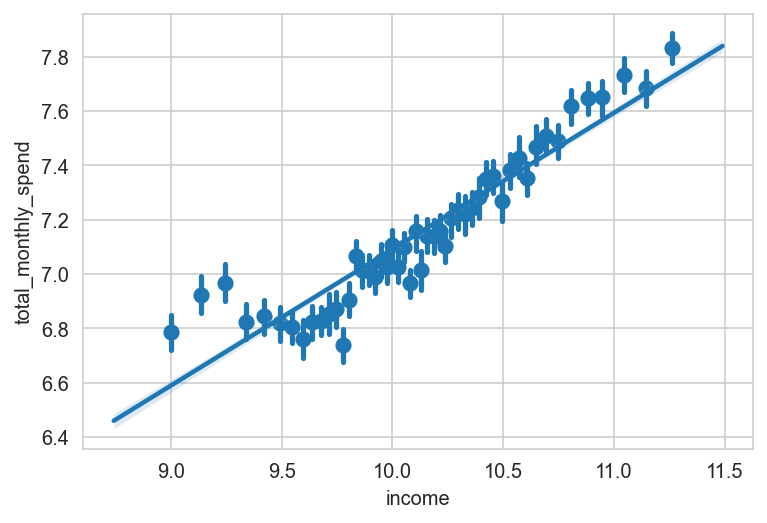

In [115]:
def trim_column_values(df, **kwargs):
    return df.apply(hd.trim, **kwargs)


def make_jointplot(df, x, y, trim_pct=0):
    data = df[[x] + [y]]
    data = trim_column_values(data, pct=trim_pct)
    data = data.applymap(np.log)
    sns.regplot(data=data, x=x, y=y, x_bins=50, ci=99)


make_jointplot(analysis_data, "income", "total_monthly_spend", trim_pct=1)

## Main results

Full FE equation as baseline

## Lagged-dependent variable